# Birth-Death Process

Previously we have simulated the growth of bacterial populations by simply assuming that cells double synchronously, so their number increases geometrically and deterministically as $N = 2^G$, where $G$ is the number of generations. In this note, we will make a more realistic (yet still very idealistic) model of population growth by incorporating the stochastic aspect of the process.

In particular, we recognize that the dynamics of the population size consists of discrete events of births and deaths of individuals, which can happen asynchronously. Therefore, we will study the process in continuous time, instead of discrete generations, and let each individual have a certain probability of giving birth to a new individual (i.e., asexual reproduction) or dying at any given time. Note that we specify only the probabilities, not the time of actual events. The process will be *stochastic* in the sense that, if we repeat the simulation, the events can happen at different times. If we plot the population size as a function of time, then the trajectories from those simulations will fluctuate in time and differ from each other.

Let us assume that every individual has a probability $\beta$ per unit time of giving birth to a new individual, and a probability $\delta$ per unit time of dying. That means, in a short period of time $dt$, the probability of having a birth or death event per individual is $\beta\,dt$ and $\delta\,dt$, respectively. Here $\beta$ and $\delta$ are called the birth rate and the death rate, respectively. The population dynamics that this model describes is called a "birth-death process".

## Deterministic approximation

We can represent such a process symbolically by the following "reactions":
\begin{alignat}{2}
\mathbb{I} &\xrightarrow{\beta} 2 \, \mathbb{I} \,, \quad &&\textsf{i.e., one individual becomes two at rate } \beta \,; \\
\mathbb{I} &\xrightarrow{\delta} \mathbb{0} \,, \quad &&\textsf{i.e., one individual becomes none at rate } \delta \,.
\end{alignat}
This representation is similar to that for chemical reactions. We can use this analogy to derive the equation that describes the dynamics of the population size, similar to the "mass action" equations for chemical reactions. The resulting equation will determine the *average* behavior of the population dynamics.

To derive the equation, suppose that at time $t$ the population size is $N(t)$. Then in a short period from $t$ to $t+dt$, the *average* number of births will be $N \beta \, dt$, and the *average* number of deaths will be $N \delta \, dt$. Therefore the population size will change by $dN = N \beta \, dt - N \delta \, dt$. This can be written as a differential equation:
\begin{equation}
\frac{dN}{dt} = (\beta - \delta) N
\end{equation}
The solution is simply:
\begin{equation}
N(t) = N_0 \, \mathrm{e}^{(\beta - \delta) t}
\end{equation}
That is, the population is expected to grow exponentially with time, with a net growth rate equal to the difference between the birth and the death rates. This is rather intuitive, and gives qualitatively the same behavior as geometric growth for synchronous generations.

As an exercise, let us numerically solve the differential equation above and compare to the analytic solution. In choosing values for $\beta$ and $\delta$, note that they both have units of 1/\[time\], so we can always rescale time to set one of them to 1. We will set the death rate $\delta = 1$, so that the average lifespan of an individual is $1/\delta = 1$, i.e., the generation timescale is $1$. In order for the population to grow, we need $\beta > \delta$, such as $\beta = 2$. We will start from $N_0 = 1$, i.e., from one individual (think about a seed that is dispersed to a new patch of soil). To solve the equation, we can discretize time into very small time steps $\Delta t$ and calculate the population growth $\Delta N$ within each time step. (This method is simple but not as accurate as some more sophisticated methods, which we will use later in the course.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
beta = 2.    # birth rate
delta = 1.    # death rate

dt = 0.01    # time step size
T = 10.    # total time to solve the equation for
t_array = np.arange(0, T, dt)    # time points to evaluate the variable N

N0 = 1    # initial population size
N_array = np.zeros(len(t_array))    # initialize values of N at every time point
N_array[0] = N0

for i in range(1, len(t_array)):
    dt = t_array[i] - t_array[i-1]    # this is true even if t_array is not uniformly spaced
    dN = N_array[i-1] * (beta - delta) * dt    # increment to first order in dt
    N_array[i] = N_array[i-1] + dN    # calculate value at next time point

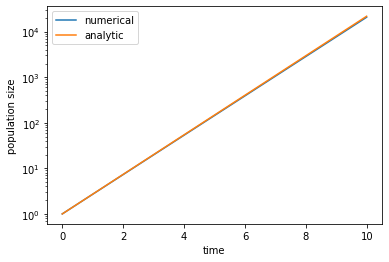

In [3]:
N_analytic = N0 * np.exp((beta - delta) * t_array)    # analytic solution

plt.figure()
plt.plot(t_array, N_array, label='numerical')
plt.plot(t_array, N_analytic, label='analytic')
plt.yscale('log')    # plot in log scale
plt.xlabel('time')
plt.ylabel('population size')
plt.legend()
plt.show()

Note that, in this solution, the population size is treated as a continuous variable, not an integer. This is because the solution is meant to describe the *average* trajectory over different realizations of the stochastic process. When the size $N$ is large, the deviation of an actual realization of the process from the average trajectory will be small. In that case the deterministic solution can be considered as a good approximation of the true stochastic process. However, when $N$ is small, fluctuations will be significant, and we will have to simulate the stochastic process more seriously.

## Stochastic simulation

Why should we care about the fluctuations in the stochastic process? Well, the fluctuations can have serious consequences. In the case of population growth, when $N$ is small, there is a real chance that all individuals happen to die before any of them gets to reproduce. Then the whole population goes extinct and will never recover. Such a scenario cannot be captured by the deterministic solution above (because $N$ was treated as a continuous variable and so would never reach zero exactly, even if it becomes $\ll 1$.) Therefore, to calculate things like the probability of the population going extinct, we need to treat the process stochastically.

One method for simulating stochastic processes like those described by the reactions above is the **Gillespie algorithm**. We will explain and use it in the following.

Consider first the birth process alone. Suppose at the moment the population size is $N$, then the *total* birth rate of the population is $\beta N$, meaning that the probability of having *one* birth event among *all* individuals in the next short time period $dt$ is $\beta N dt$. This is similar to the Poisson process that we learned before, where there is a rate $k$ that certain events happen. Recall that the waiting time $\tau$ before the next event happens is exponentially distributed, $P(\tau) = k \, \mathrm{e}^{-k \tau}$. Therefore, to simulate the occurrence of the next birth event, we just need to draw a random number $\tau$ from the exponential distribution with $k = \beta N$.

Now let us also include the death process. Like above, the total death rate among the population is $\delta N$. Therefore the time before the next death event is exponentially distributed with $k = \delta N$. We can draw a random number from this distribution to be the time at which the next death would happen. However, we need to account for both birth and death events. There are several ways to do that. One intuitive way (the so-called "first-reaction" method of the Gillespie algorithm) is to first generate two random numbers, corresponding to the *putative* times for the next birth and death event respectively. We then compare these numbers to see which event would happen first, and execute only this first event. That is because, after this event, the population size will change (plus or minus one depending on whether the event is a birth or death), and hence the total birth and death rates among the population will change accordingly. So we will have to start over by calculting the new total birth and death rates, drawing two new random numbers as the putative times for the next birth or death event, etc. In this way, the simulation proceeds one event at a time. Note that, in such a simulation, the population size $N$ is always an integer and time is a continuous variable, as compared to the deterministic solution above where $N$ is continuous and time is discretized.

Let us write a Python class to simulate the birth-death process using the Gillespie algorithm as described above.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class BirthDeath:
    """
    simulate the birth-death process using Gillespie algorithm.
    """
    
    def __init__(self, birth_rate, death_rate=1., N0=1):
        """
        initialize the population.
        inputs:
        birth_rate: float, birth rate per individual.
        death_rate: float, death rate per individual.
        N0: int, initial population size.
        """
        self.birth_rate = birth_rate
        self.death_rate = death_rate
        self.pop_size = N0    # current population size
        self.time = 0.    # time since beginning of simulation
        self.pop_hist = [N0]    # list to record history of population size
        self.time_hist = [0.]    # list to record time of all events
    
    def next_event(self):
        """
        generate the waiting time and identity of the next event.
        outputs:
        tau: float, waiting time before next event.
        event: int, 0 means birth and 1 means death.
        """
        k_b = self.pop_size * self.birth_rate    # total birth rate
        k_d = self.pop_size * self.death_rate    # total death rate
        t_b = np.random.exponential(1/k_b)    # draw a random number from exponential dist as putative birth time
        t_d = np.random.exponential(1/k_d)    # draw a random number from exponential dist as putative death time
        if t_b < t_d:    # birth happens first
            event = 0    # use 0 to label birth
            return t_b, event
        else:    # death happens first
            event = 1    # use 1 to label death
            return t_d, event
    
    def run(self, T):
        """
        run simulation until time T since the beginning.
        inputs:
        T: float, time since the beginning of the simulation.
        """
        while self.time < T:
            if self.pop_size == 0:    # population is extinct
                break    # exit while loop to end simulation
            tau, event = self.next_event()    # draw next event
            self.time += tau    # update time
            if event == 0:    # birth happens
                self.pop_size += 1    # increase population size by 1
            elif event == 1:    # death happens
                self.pop_size -= 1    # decrease population size by 1
            self.time_hist.append(self.time)    # record time of event
            self.pop_hist.append(self.pop_size)    # record population size after event

Now let us test this class by running the simulation several times and plotting these realizations of the stochastic process.

In [5]:
beta = 2.    # birth rate
delta = 1.    # death rate

T = 10.    # total time for running each simulation
trials = 10    # number of simulations to repeat
bd_list = []    # list to save all simulations

for i in range(trials):
    bd1 = BirthDeath(beta, delta)    # create a simulation
    bd1.run(T)    # run simulation until time T
    print(f'current time = {bd1.time}, current population size = {bd1.pop_size}')
    bd_list.append(bd1)    # save the simulation in a list

current time = 10.000008613756664, current population size = 58530
current time = 10.00000353379543, current population size = 28281
current time = 10.000004011786409, current population size = 21343
current time = 10.000001743706804, current population size = 70183
current time = 0.3460562000994244, current population size = 0
current time = 2.8762221984809395, current population size = 0
current time = 10.000002400358154, current population size = 58945
current time = 0.6621550854798959, current population size = 0
current time = 1.6860558927602003, current population size = 0
current time = 0.29505707715923196, current population size = 0


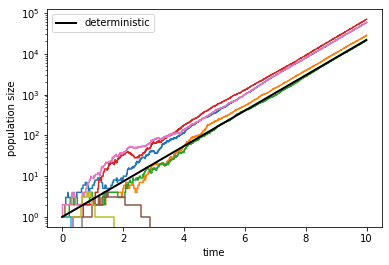

In [6]:
plt.figure()
for bd1 in bd_list:
    plt.plot(bd1.time_hist, bd1.pop_hist, drawstyle='steps-post')    # stochastic realizations
plt.plot(t_array, N_analytic, 'k', linewidth=2, label='deterministic')    # deterministic solution from above
plt.yscale('log')
plt.xlabel('time')
plt.ylabel('population size')
plt.legend(loc='upper left')
plt.show()

Hopefully you see a few trajectories that did not go extinct. For those trajectories, you should see that asymptotically they grow exponentially at the same rate as the deterministic solution we found above. However, you may also see a few trajectories that went extinct, usually pretty early on. These are due to stochastic fluctuations that are significant when $N$ is small. Once the population size has reached a certain level, say $N > 100$, extinction becomes extremely unlikely.

## Extinction probability

The stochastic simulation allows us to estimate the probability that extinction happens --- something that could not be calculated from the deterministic solution above. To do that, we need to run the simulation many times to collect the statistics. To save some running time, we will run each simulation only until $T=5$, by which time most extinctions would have happened.

In [7]:
trials = 1000    # number of simulations to run
T = 5.    # total time for running each simulation
extinct = 0    # number of extinctions among all trials

for i in range(trials):
    print(f'running simulation #{i+1}/{trials}', end='\r')    # print progress
    bd1 = BirthDeath(beta, delta)
    bd1.run(T)
    if bd1.pop_size == 0:
        extinct += 1

PE = extinct / trials
print(f'Extinction happened {extinct} out of {trials} times.')
print(f'estimated extinction probability = {PE}')

Extinction happened 518 out of 1000 times.
estimated extinction probability = 0.518


Mathematically, one can show that the probability of extinction in such a birth-death process is given by $q = \delta / \beta$. In our example this should be $0.5$. You can see that the estimate from our simulations is pretty close!

Finally, let us examine how the extinction probability depends on the initial population size. In the example above, we assumed $N_0 = 1$, i.e., the population is founded by one individual alone. With more founders, we may expect the extinction probability to be smaller, because it takes a larger and rarer fluctuation for all of them to die.

Let us run simulations with different initial sizes of the population.

In [8]:
N0_list = np.arange(1, 9)    # list of initial sizes to use
PE_list = []    # list of extinction probability for each initial size

trials = 1000    # number of simulations to run
T = 5.    # total time for running each simulation

for N0 in N0_list:
    extinct = 0    # number of extinctions among all trials
    for i in range(trials):
        print(f'running simulation #{i+1}/{trials}', end='\r')    # print progress
        bd1 = BirthDeath(beta, delta, N0=N0)    # specify initial population size N0
        bd1.run(T)
        if bd1.pop_size == 0:
            extinct += 1
    PE = extinct / trials    # estimate extinction probability
    PE_list.append(PE)    # save extinction probability for given initial size
    print(f'N0 = {N0}: estimated extinction probability = {PE}')

N0 = 1: estimated extinction probability = 0.488
N0 = 2: estimated extinction probability = 0.23
N0 = 3: estimated extinction probability = 0.135
N0 = 4: estimated extinction probability = 0.056
N0 = 5: estimated extinction probability = 0.034
N0 = 6: estimated extinction probability = 0.013
N0 = 7: estimated extinction probability = 0.008
N0 = 8: estimated extinction probability = 0.004


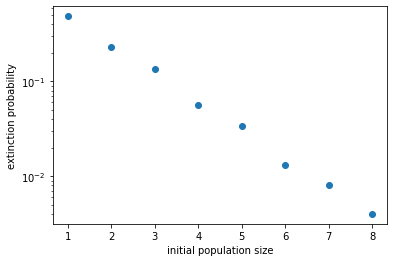

In [9]:
plt.figure()
plt.plot(N0_list, PE_list, 'o', label='data')
plt.yscale('log')
plt.xlabel('initial population size')
plt.ylabel('extinction probability')
plt.show()

From the figure it looks like the extinction probability decreases exponentially with initial population size. Indeed, it can be mathematically shown that the extinction probability is simply $Q = q^{N_0} = (\delta/\beta)^{N_0}$. This can be intuitively understood, because in our model the individuals are all independent of each other. Therefore an initial population of $N_0$ individuals can be thought of as $N_0$ populations of one individual each. Since each of these populations has a probability $q$ of going extinct, the probability that they all go extinct is $q^{N_0}$. This relation fits our data pretty well, as shown below.

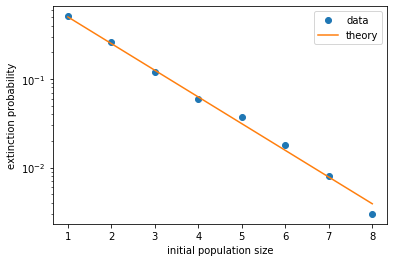

In [10]:
plt.figure()
plt.plot(N0_list, PE_list, 'o', label='data')    # plot simulation results
plt.plot(N0_list, (delta/beta)**N0_list, label='theory')    # plot theoretical curve
plt.yscale('log')
plt.xlabel('initial population size')
plt.ylabel('extinction probability')
plt.legend()
plt.show()

It also explains why extinction becomes extremely unlikely when the population reaches a decent size, such as $N > 100$. In that case, the probability that the population will go extinct in future is $Q < q^{100} \sim 10^{-30}$!